In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='whitegrid', palette='muted')

In [2]:
ratings = pd.read_csv('u.data', sep='\t',
    names=['user_id','movie_id','rating','timestamp'])

movies = pd.read_csv('u.item', sep='|', encoding='latin-1',
    usecols=[0,1], names=['movie_id','title'])

users = pd.read_csv('u.user', sep='|',
    names=['user_id','age','gender','occupation','zip_code'])

print(f"Ratings:   {len(ratings):,}")
print(f"Usuarios:  {ratings['user_id'].nunique():,}")
print(f"Películas: {ratings['movie_id'].nunique():,}")
ratings.head()

Ratings:   100,000
Usuarios:  943
Películas: 1,682


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


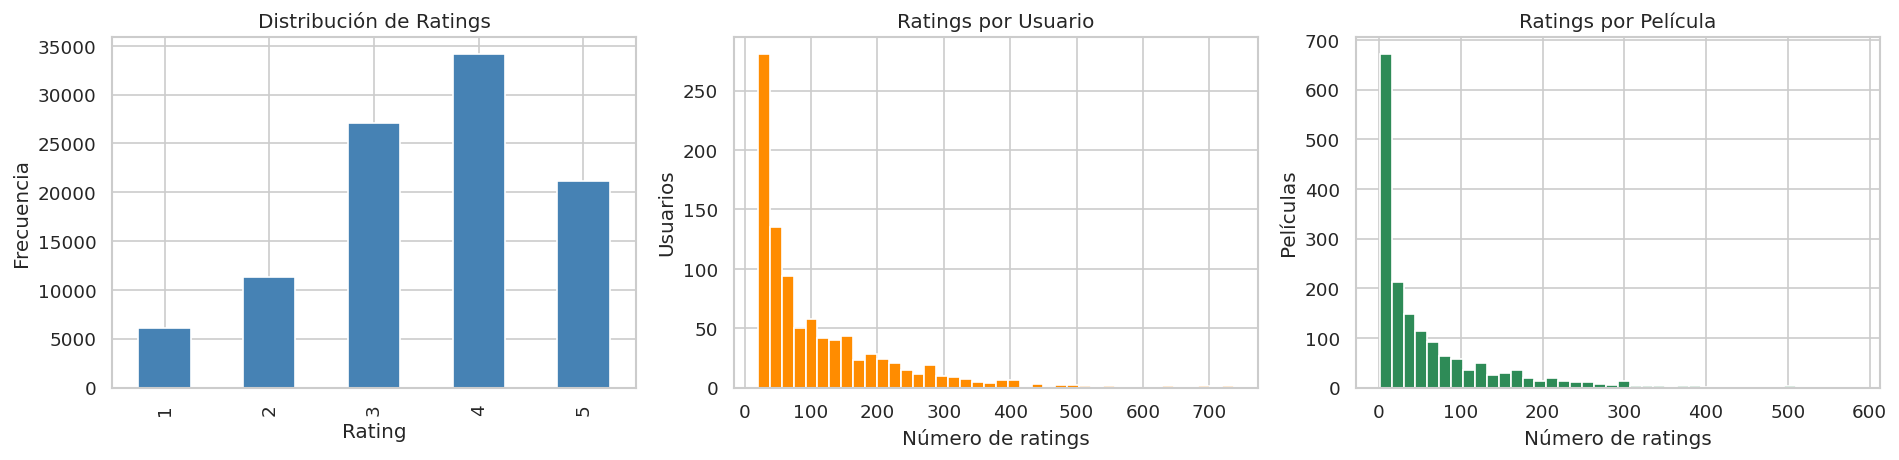

Densidad:  6.30%
Sparsity:  93.70%


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ratings['rating'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Distribución de Ratings')
axes[0].set_xlabel('Rating'); axes[0].set_ylabel('Frecuencia')

ratings.groupby('user_id')['rating'].count().pipe(
    lambda s: axes[1].hist(s, bins=40, color='darkorange', edgecolor='white'))
axes[1].set_title('Ratings por Usuario')
axes[1].set_xlabel('Número de ratings'); axes[1].set_ylabel('Usuarios')

ratings.groupby('movie_id')['rating'].count().pipe(
    lambda s: axes[2].hist(s, bins=40, color='seagreen', edgecolor='white'))
axes[2].set_title('Ratings por Película')
axes[2].set_xlabel('Número de ratings'); axes[2].set_ylabel('Películas')

plt.tight_layout()
plt.savefig('eda_movielens.png', bbox_inches='tight')
plt.show()

density = len(ratings) / (ratings['user_id'].nunique() * ratings['movie_id'].nunique())
print(f"Densidad:  {density*100:.2f}%")
print(f"Sparsity:  {(1-density)*100:.2f}%")

In [4]:
R = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
user_mean = R.mean(axis=1)
R_centered = R.sub(user_mean, axis=0)

print(f"Dimensiones de R: {R.shape}")

Dimensiones de R: (943, 1682)


In [5]:
k = 50
U, sigma, Vt = svds(R_centered.values, k=k)
U = U[:,::-1]; sigma = sigma[::-1]; Vt = Vt[::-1,:]

print(f"U:     {U.shape}")
print(f"Sigma: {sigma.shape}")
print(f"Vt:    {Vt.shape}")
print(f"Top 10 valores singulares: {np.round(sigma[:10], 2)}")

U:     (943, 50)
Sigma: (50,)
Vt:    (50, 1682)
Top 10 valores singulares: [522.23 244.38 217.36 159.09 157.79 138.41 126.08 111.51 106.57  99.68]


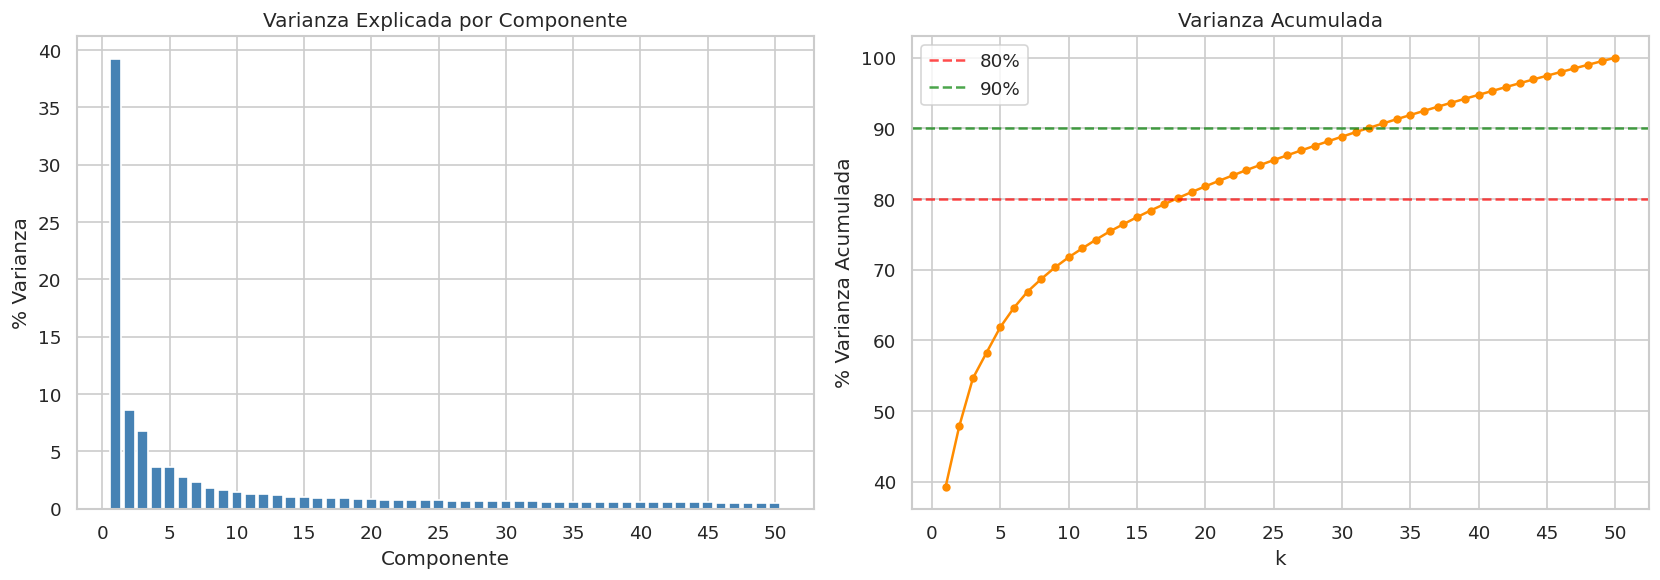

k para ≥80%: 18
k para ≥90%: 32
Varianza con k=50: 100.00%


In [6]:
var_exp = sigma**2 / np.sum(sigma**2)
cum_var = np.cumsum(var_exp)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, k+1), var_exp*100, color='steelblue', edgecolor='white')
axes[0].set_title('Varianza Explicada por Componente')
axes[0].set_xlabel('Componente'); axes[0].set_ylabel('% Varianza')
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))

axes[1].plot(range(1, k+1), cum_var*100, 'o-', color='darkorange', markersize=4)
axes[1].axhline(80, color='red',   linestyle='--', alpha=0.7, label='80%')
axes[1].axhline(90, color='green', linestyle='--', alpha=0.7, label='90%')
axes[1].set_title('Varianza Acumulada')
axes[1].set_xlabel('k'); axes[1].set_ylabel('% Varianza Acumulada')
axes[1].legend(); axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.tight_layout()
plt.savefig('svd_variance.png', bbox_inches='tight')
plt.show()

print(f"k para ≥80%: {np.argmax(cum_var>=0.80)+1}")
print(f"k para ≥90%: {np.argmax(cum_var>=0.90)+1}")
print(f"Varianza con k=50: {cum_var[-1]*100:.2f}%")

In [7]:
R_pred = np.dot(np.dot(U, np.diag(sigma)), Vt) + user_mean.values.reshape(-1, 1)
R_pred_df = pd.DataFrame(R_pred, index=R.index, columns=R.columns).clip(1, 5)

print(f"Rango predicciones: [{R_pred_df.values.min():.2f}, {R_pred_df.values.max():.2f}]")

Rango predicciones: [1.00, 5.00]


In [8]:
train = pd.read_csv('u1.base', sep='\t', names=['user_id','movie_id','rating','timestamp'])
test  = pd.read_csv('u1.test', sep='\t', names=['user_id','movie_id','rating','timestamp'])

R_tr = train.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mean_tr = R_tr.mean(axis=1)
R_tr_c = R_tr.sub(mean_tr, axis=0)

U_tr, sig_tr, Vt_tr = svds(R_tr_c.values, k=100)
U_tr = U_tr[:,::-1]; sig_tr = sig_tr[::-1]; Vt_tr = Vt_tr[::-1,:]

k_values = [5, 10, 20, 30, 50, 75, 100]
rmse_values = []

for kv in k_values:
    R_a = np.dot(np.dot(U_tr[:,:kv], np.diag(sig_tr[:kv])), Vt_tr[:kv,:])
    R_a += mean_tr.values.reshape(-1,1)
    R_a_df = pd.DataFrame(R_a, index=R_tr.index, columns=R_tr.columns).clip(1,5)

    preds, actuals = [], []
    for _, row in test.iterrows():
        uid, mid, actual = row['user_id'], row['movie_id'], row['rating']
        if uid in R_a_df.index and mid in R_a_df.columns:
            preds.append(R_a_df.loc[uid, mid])
            actuals.append(actual)

    rmse = sqrt(mean_squared_error(actuals, preds))
    rmse_values.append(rmse)

rmse_df = pd.DataFrame({'k': k_values, 'RMSE': rmse_values})
print(rmse_df.to_string(index=False))

  k     RMSE
  5 2.589094
 10 2.555284
 20 2.550370
 30 2.574311
 50 2.621021
 75 2.669133
100 2.707442


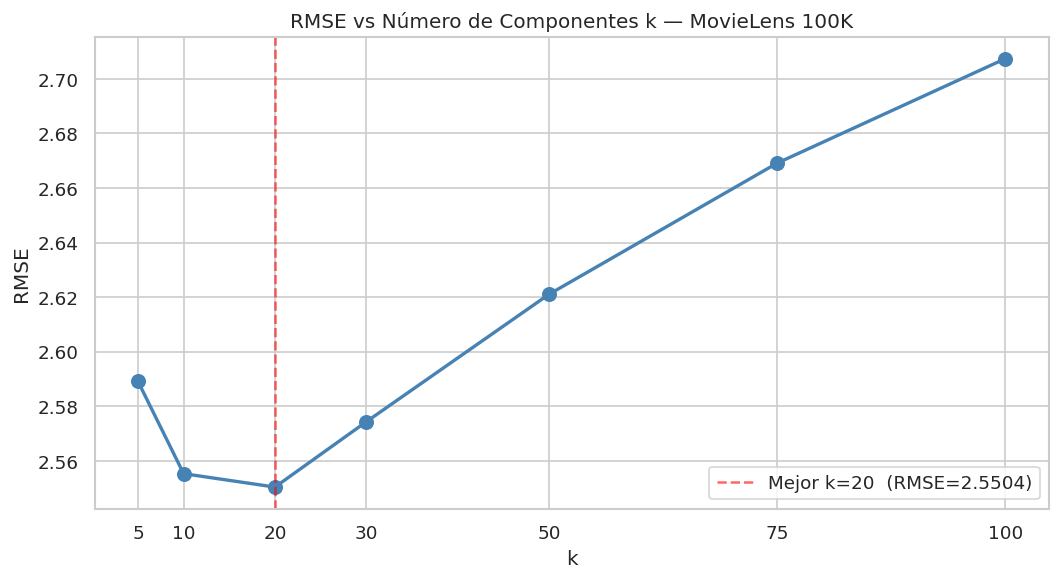

In [9]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(k_values, rmse_values, 'o-', color='steelblue', linewidth=2, markersize=8)
ax.set_title('RMSE vs Número de Componentes k — MovieLens 100K')
ax.set_xlabel('k'); ax.set_ylabel('RMSE')
ax.xaxis.set_major_locator(ticker.FixedLocator(k_values))

best_k = k_values[np.argmin(rmse_values)]
best_rmse = min(rmse_values)
ax.axvline(best_k, color='red', linestyle='--', alpha=0.6,
           label=f'Mejor k={best_k}  (RMSE={best_rmse:.4f})')
ax.legend()
plt.tight_layout()
plt.savefig('svd_rmse_vs_k.png', bbox_inches='tight')
plt.show()

In [10]:
def recomendar(user_id, n=10):
    ya_vistas = ratings[ratings['user_id']==user_id]['movie_id'].tolist()
    preds = R_pred_df.loc[user_id].drop(index=ya_vistas, errors='ignore')
    top = preds.nlargest(n)
    res = movies[movies['movie_id'].isin(top.index)].copy()
    res['predicted_rating'] = res['movie_id'].map(top)
    return res[['movie_id','title','predicted_rating']].sort_values(
        'predicted_rating', ascending=False).reset_index(drop=True)

recomendar(196)

,movie_id,title,predicted_rating
0,216,When Harry Met Sally... (1989),1.677965
1,204,Back to the Future (1985),1.498263
2,451,Grease (1978),1.375334
3,732,Dave (1993),1.325541
4,88,Sleepless in Seattle (1993),1.216387
5,14,"Postino, Il (1994)",1.212675
6,274,Sabrina (1995),1.157167
7,211,M*A*S*H (1970),1.156852
8,367,Clueless (1995),1.138778
9,303,Ulee's Gold (1997),1.138002


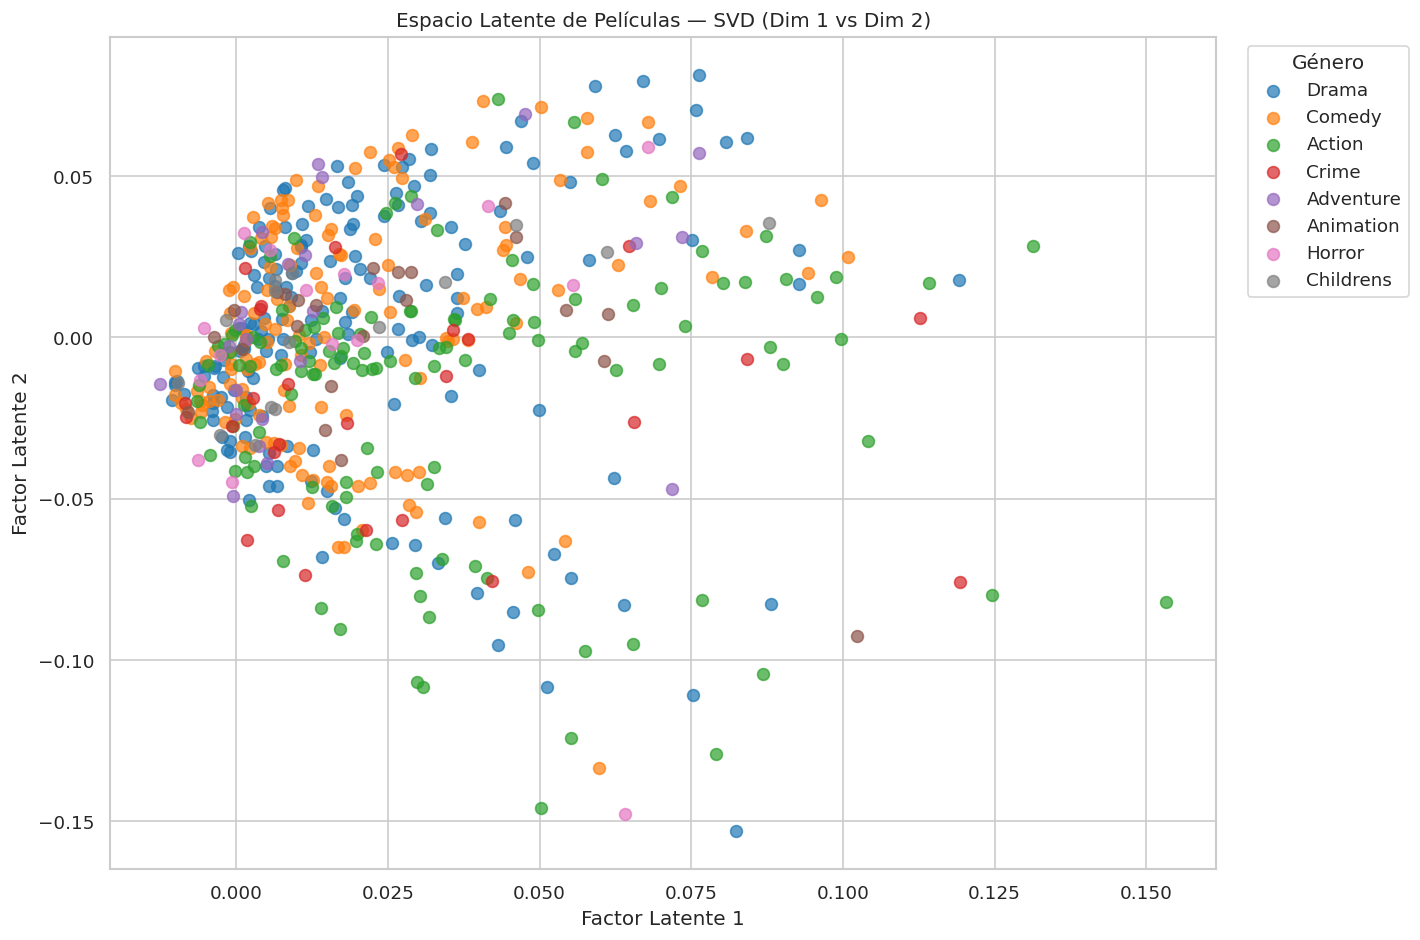

In [11]:
genre_cols = ['unknown','Action','Adventure','Animation','Childrens','Comedy',
              'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
              'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

items_full = pd.read_csv('u.item', sep='|', encoding='latin-1',
    names=['movie_id','title','release_date','video_release','imdb_url']+genre_cols)

def primary_genre(row):
    for g in genre_cols:
        if row[g] == 1:
            return g
    return 'Unknown'

items_full['genre'] = items_full.apply(primary_genre, axis=1)

mf = pd.DataFrame(Vt[:2,:].T, index=R.columns, columns=['dim1','dim2']).reset_index()
mf.columns = ['movie_id','dim1','dim2']
mf = mf.merge(items_full[['movie_id','title','genre']], on='movie_id')

pop = ratings.groupby('movie_id')['rating'].count()
mf_pop = mf[mf['movie_id'].isin(pop[pop>=50].index)]

fig, ax = plt.subplots(figsize=(12, 8))
genres_top = mf_pop['genre'].value_counts().head(8).index
palette = sns.color_palette('tab10', 8)

for i, g in enumerate(genres_top):
    sub = mf_pop[mf_pop['genre']==g]
    ax.scatter(sub['dim1'], sub['dim2'], label=g, alpha=0.7, s=50, color=palette[i])

ax.set_title('Espacio Latente de Películas — SVD (Dim 1 vs Dim 2)')
ax.set_xlabel('Factor Latente 1'); ax.set_ylabel('Factor Latente 2')
ax.legend(title='Género', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.savefig('svd_latent_space.png', bbox_inches='tight')
plt.show()

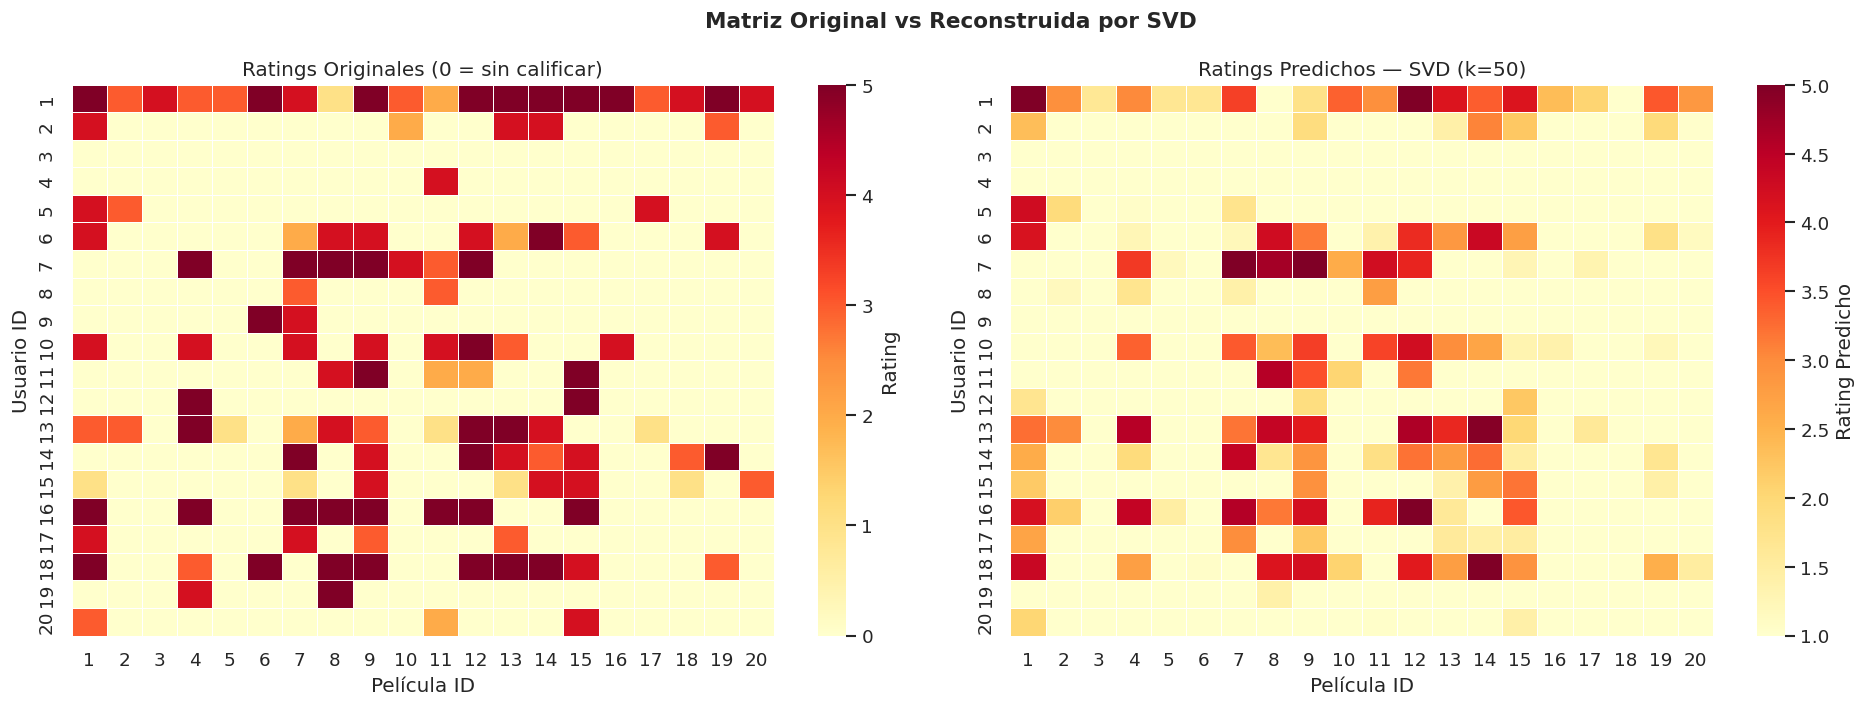

In [12]:
su = R.index[:20]
sm = R.columns[:20]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(R.loc[su, sm], ax=axes[0], cmap='YlOrRd', vmin=0, vmax=5,
            linewidths=0.3, cbar_kws={'label':'Rating'})
axes[0].set_title('Ratings Originales (0 = sin calificar)')
axes[0].set_xlabel('Película ID'); axes[0].set_ylabel('Usuario ID')

sns.heatmap(R_pred_df.loc[su, sm], ax=axes[1], cmap='YlOrRd', vmin=1, vmax=5,
            linewidths=0.3, cbar_kws={'label':'Rating Predicho'})
axes[1].set_title('Ratings Predichos — SVD (k=50)')
axes[1].set_xlabel('Película ID'); axes[1].set_ylabel('Usuario ID')

plt.suptitle('Matriz Original vs Reconstruida por SVD', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('svd_heatmap.png', bbox_inches='tight')
plt.show()